In this notebook, we will apply ordinary least square (OLS) fit and Bayesian linear regression, respectively, on the auto MPG data set, which is available on UCI repository: http://archive.ics.uci.edu/ml/datasets/Auto+MPG 

The dataset has 9 attributes:

1. mpg:           continuous
2. cylinders:     multi-valued discrete
3. displacement:  continuous
4. horsepower:    continuous
5. weight:        continuous
6. acceleration:  continuous
7. model year:    multi-valued discrete
8. origin:        multi-valued discrete
9. car name:      string (unique for each instance)

We will treat the first attribute, mpg, as a continuous target and the rest as predictors to build a linear regression model.

In the following, we will discard the `car name` due to its high cardinality, and treat `cylinders` and `origin` as categorical features.

In [2]:
import numpy as np
import pandas as pd
import patsy 
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
import pymc3 as pm
import pymc3.glm

import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline


In [3]:
def adjustAxeProperties(ax_obj, x_fontsize, x_rotation, y_fontsize, y_rotation):
    for tick in ax_obj.xaxis.get_major_ticks():
        tick.label.set_fontsize(x_fontsize)
        tick.label.set_rotation(x_rotation)
    for tick in ax_obj.yaxis.get_major_ticks():
        tick.label.set_fontsize(y_fontsize)
        tick.label.set_rotation(y_rotation)

# Load data

In [4]:
raw_data = pd.read_csv('auto-mpg.data', delim_whitespace=True, header=None)
raw_data.columns = ['mpg', 'cylinders', 'displacement', 'horsepower', 'weight', 
                    'acceleration', 'model_year', 'origin', 'car_name']

In [5]:
raw_data.shape

(398, 9)

In [6]:
raw_data.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,car_name
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693.0,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436.0,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433.0,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449.0,10.5,70,1,ford torino


# Preprocessing features

The attribute `horsepower` has missing values, so for simplicity we will impute the missing values with the average horsepower.

In [7]:
def processHorsepower(x):
    try:
        hp = float(x)
        return hp
    except:
        return np.nan
raw_data['horsepower'] = raw_data['horsepower'].apply(processHorsepower)

avg_hp = raw_data['horsepower'].mean()

idx = raw_data[pd.isnull(raw_data['horsepower'])].index
raw_data.at[idx, 'horsepower'] = avg_hp

Convert `cylinders` and `origin` to string so that they can be correctly treated as categorical features in patsy's formula interface.

In [8]:
raw_data['cylinders'] = raw_data['cylinders'].astype(str)
raw_data['origin'] = raw_data['origin'].astype(str)

Define our target and features, then use patsy's formula interface to generate the design matrix

In [9]:
target = 'mpg'
numerical_features = ['displacement', 'horsepower', 'weight', 'acceleration', 'model_year']
scaled_numerical_features = ['scaled_' + feat for feat in numerical_features]
categorical_features = ['cylinders', 'origin']

features = categorical_features + scaled_numerical_features 
formula = '{} ~ '.format(target) + ' + '.join(features)

In [10]:
formula

'mpg ~ cylinders + origin + scaled_displacement + scaled_horsepower + scaled_weight + scaled_acceleration + scaled_model_year'

We will also normalize the numerical features

In [11]:
scalar = StandardScaler(copy=True, with_mean=True, with_std=True)
scalar.fit(raw_data[numerical_features])
scaled_numerical_data = pd.DataFrame(scalar.transform(raw_data[numerical_features]), 
                                     columns=scaled_numerical_features)

In [12]:
data = pd.concat([raw_data[[target] + categorical_features], scaled_numerical_data], axis=1)

In [13]:
data.head()

,mpg,cylinders,origin,scaled_displacement,scaled_horsepower,scaled_weight,scaled_acceleration,scaled_model_year
0,18.0,8,1,1.090604,0.669196,0.630870,-1.295498,-1.627426
1,15.0,8,1,1.503514,1.586599,0.854333,-1.477038,-1.627426
2,18.0,8,1,1.196232,1.193426,0.550470,-1.658577,-1.627426
3,16.0,8,1,1.061796,1.193426,0.546923,-1.295498,-1.627426
4,17.0,8,1,1.042591,0.931311,0.565841,-1.840117,-1.627426


# Linear regression (OLS)

In [14]:
(y, X) = patsy.dmatrices(formula, data, return_type='dataframe')
lin_reg = sm.OLS(y, X).fit()

In [15]:
lin_reg.params

Intercept              17.036075
cylinders[T.4]          6.674063
cylinders[T.5]          7.035956
cylinders[T.6]          3.545461
cylinders[T.8]          5.389210
origin[T.2]             1.965965
origin[T.3]             2.598741
scaled_displacement     1.917220
scaled_horsepower      -1.107085
scaled_weight          -5.161839
scaled_acceleration     0.142622
scaled_model_year       2.754680
dtype: float64

In [16]:
lin_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    mpg   R-squared:                       0.846
Model:                            OLS   Adj. R-squared:                  0.841
Method:                 Least Squares   F-statistic:                     192.6
Date:                Sun, 26 Nov 2017   Prob (F-statistic):          3.42e-149
Time:                        12:12:10   Log-Likelihood:                -1010.5
No. Observations:                 398   AIC:                             2045.
Df Residuals:                     386   BIC:                             2093.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              17.0361      1.739      9.795      0.000      13.616      20.456
cylinders[T.4]          6.6741      1.661      4.019      0.000       3.409       9.939
cylinders[T.5]          7.0360      2.526      2.785      0.006       2.069      12.003
cylinders[T.6]          3.5455      1.831      1.937      0.053      -0.054       7.144
cylinders[T.8]          5.3892      2.115      2.548      0.011       1.231       9.548
origin[T.2]             1.9660      0.544      3.616      0.000       0.897       3.035
origin[T.3]             2.5987      0.523      4.971      0.000       1.571       3.627
scaled_displacement     1.9172      0.752      2.549      0.011       0.438       3.396
scaled_horsepower      -1.1071      0.484     -2.289      0.023      -2.058      -0.156
scaled_weight          -5.1618      0.525     -9.836      0.000      -6.194      -4.130
scaled_acceleration     0.1426      0.250      0.571      0.568      -0.349       0.634
scaled_model_year       2.7547      0.178     15.445      0.000       2.404       3.105
==============================================================================
Omnibus:                       40.910   Durbin-Watson:                   1.305
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               72.282
Skew:                           0.626   Prob(JB):                     2.01e-16
Kurtosis:                       4.671   Cond. No.                         50.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The above summary shows that OLS yields pretty decent results ($R^2 = 0.85$), and all the coefficients except for the `acceleration` are statistically significant. 

It makes sense to see that `weight` has negative coefficient, implying that larger weights will decrease mpg.


# Bayesian linear regression

Now, as an alternative to OLS, we will perform Bayesian linear regression on the same dataset. 

We assume the following formula:

$
\vec{y} = \mathcal{N}(\mathbf{X} \beta, \sigma^2)
$

In [17]:
BURN_IN_STEPS = 1000
MCMC_STEPS = 4000
with pm.Model() as model:
    pm.glm.GLM.from_formula(formula=formula, data=data, family='normal')
    start_MAP = pm.find_MAP()
    trace = pm.sample(BURN_IN_STEPS+MCMC_STEPS, start=start_MAP, step=pm.NUTS())
    trace = trace[BURN_IN_STEPS:]
    

logp = -1,099.4, ||grad|| = 0.086394: 100%|██████████| 120/120 [00:00<00:00, 1625.37it/s] 
100%|██████████| 5500/5500 [00:47<00:00, 115.84it/s]


In [18]:
pm_summary_df = pm.df_summary(trace)

In [19]:
pm_summary_df

,mean,sd,mc_error,hpd_2.5,hpd_97.5
Intercept,17.079827,1.723295,0.051658,13.860312,20.477897
cylinders[T.4],6.629137,1.649485,0.047612,3.268082,9.671424
cylinders[T.5],6.979135,2.456580,0.059145,2.187574,11.721486
cylinders[T.6],3.507278,1.808765,0.054761,0.112405,7.032603
cylinders[T.8],5.345230,2.101031,0.062292,1.268543,9.387569
origin[T.2],1.979878,0.552538,0.009977,0.861495,3.021894
origin[T.3],2.600130,0.526783,0.009232,1.610945,3.658061
scaled_displacement,1.915035,0.751756,0.019106,0.484256,3.406145
scaled_horsepower,-1.103259,0.484549,0.009927,-2.075996,-0.189075
scaled_weight,-5.161234,0.532278,0.010863,-6.217872,-4.155809


# Bayesian versus OLS 

In [21]:
compare_df = pd.concat([pm_summary_df['mean'], lin_reg.params], axis=1)
compare_df.columns = ['Bayesian', 'OLS']
compare_df

,Bayesian,OLS
Intercept,17.079827,17.036075
cylinders[T.4],6.629137,6.674063
cylinders[T.5],6.979135,7.035956
cylinders[T.6],3.507278,3.545461
cylinders[T.8],5.345230,5.389210
origin[T.2],1.979878,1.965965
origin[T.3],2.600130,2.598741
scaled_acceleration,0.143793,0.142622
scaled_displacement,1.915035,1.917220
scaled_horsepower,-1.103259,-1.107085


The comparison above shows that Bayesian regression and OLS results are pretty consistent.

## MCMC trace plots 

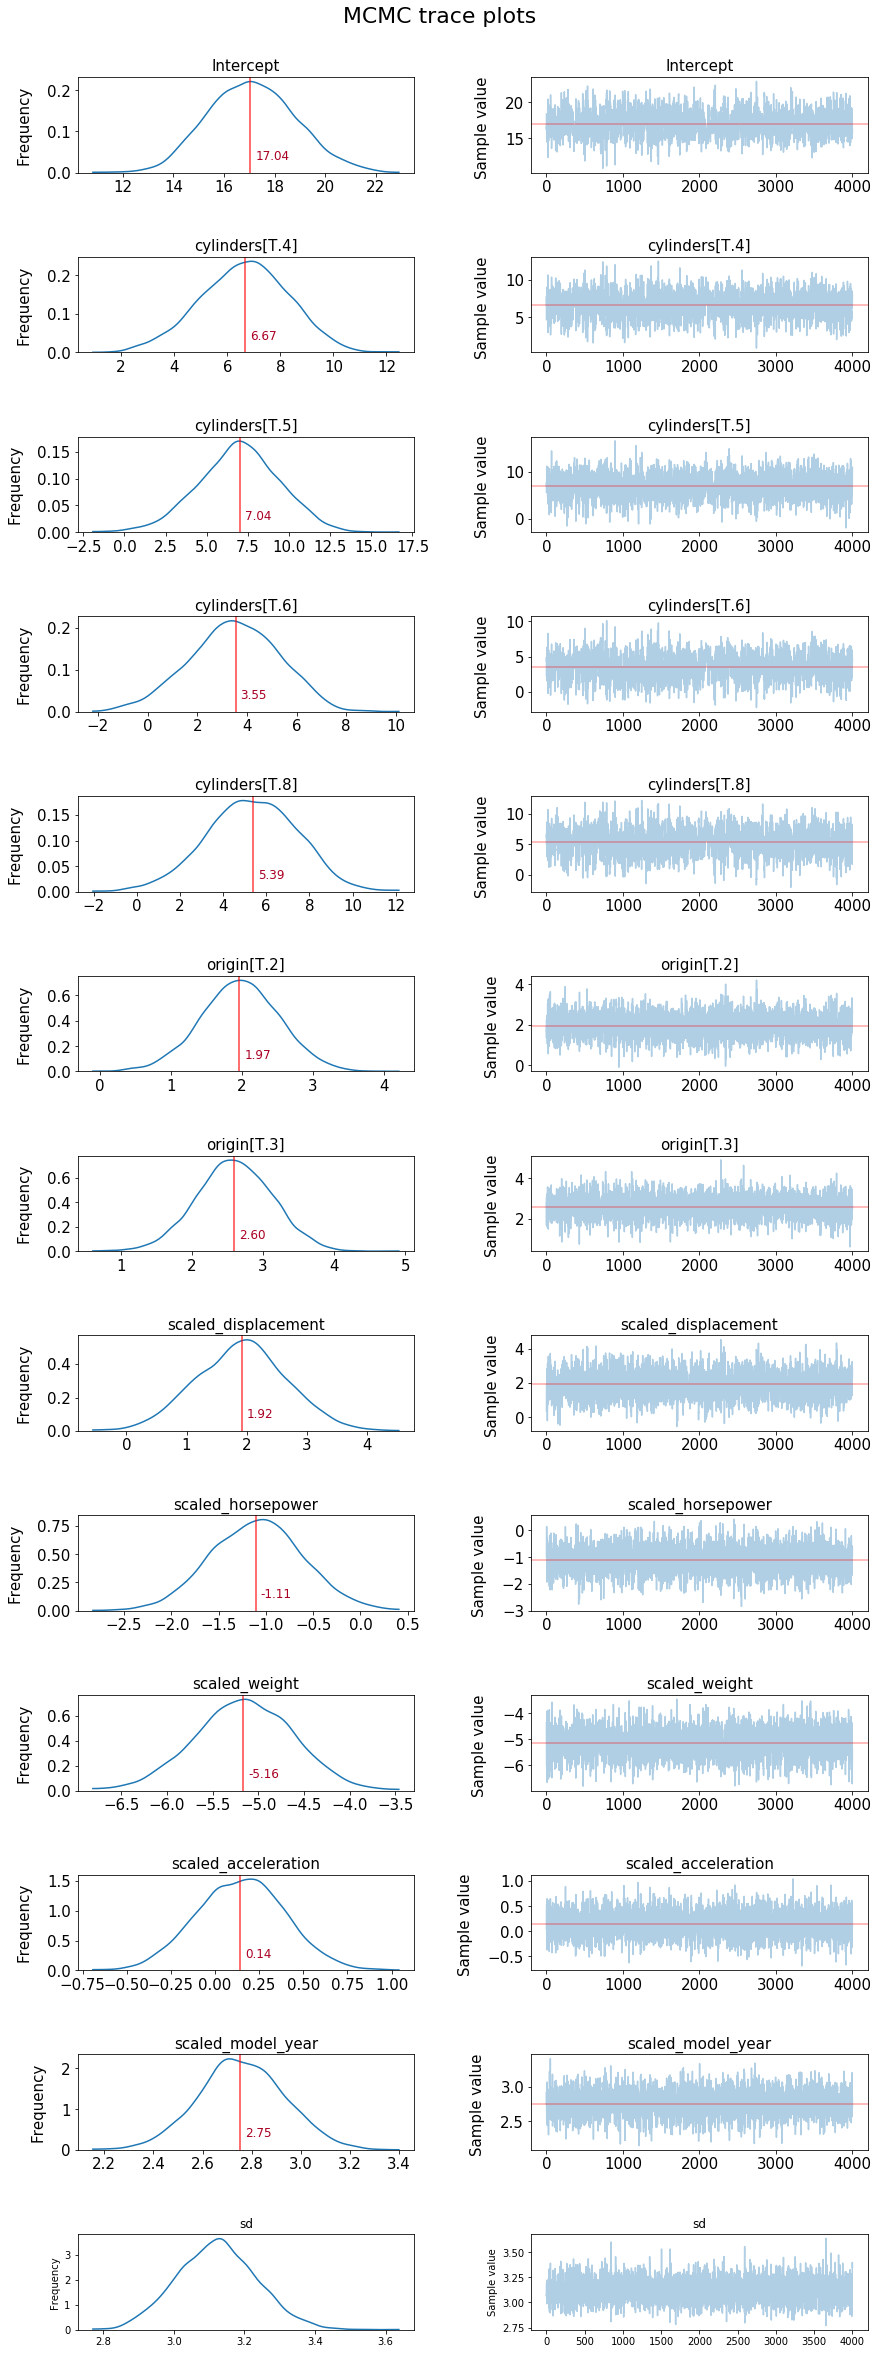

In [20]:
plt.close('all')

nrows = len(pm_summary_df)
varnames = pm_summary_df.index.tolist()
axes = pm.traceplot(trace, varnames=varnames, figsize=(12, nrows*2.5),
                    lines=lin_reg.params.to_dict())

for i, coeff in enumerate(lin_reg.params):
    axes[i, 0].annotate('{0:.2f}'.format(coeff), xy=(coeff, 0), xytext=(5, 10),
                        xycoords='data', textcoords='offset points', rotation=0,
                        va='bottom', fontsize='large', color='#AA0022')
    
    adjustAxeProperties(axes[i, 0], 15, 0, 15, 0)    
    axes[i, 0].set_xlabel(' ', fontsize=0, labelpad=5)
    axes[i, 0].set_ylabel('Frequency', fontsize=15, labelpad=15)
    axes[i, 0].set_title(varnames[i], fontsize=15)
    
    adjustAxeProperties(axes[i, 1], 15, 0, 15, 0)    
    axes[i, 1].set_xlabel(' ', fontsize=0, labelpad=5)
    axes[i, 1].set_ylabel('Sample value ', fontsize=15, labelpad=15)
    axes[i, 1].set_xticks(np.linspace(0, MCMC_STEPS, 5))
    axes[i, 1].set_title(varnames[i], fontsize=15)

    
st = plt.suptitle('MCMC trace plots', fontsize=22)
plt.tight_layout(pad=0, w_pad=4, h_pad=4)
st.set_y(1.0)
plt.subplots_adjust(top=0.97)
plt.savefig('auto_mpg_Bayesian_regression.png', bbox_inches='tight')

In the above trace plots, the blue lines are from MCMC posterior samplings, and the red lines are from the OLS fit. 
We can see that the OLS values are around the peaks of the posterior distributions. The OLS values are also very close to the posterior means. 